In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

# deepOF model stability

Given a dataset and a set of trained models, this notebook allows the user to 

* Group all weights according to their parameters
* Load the corresponding models
* Compute cluster assignment for a series of data points
* Compute and visualize the Adjusted Rand Index for each group

In [3]:
import os

os.chdir(os.path.dirname("../"))

In [100]:
import deepof.data
import deepof.utils
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from itertools import combinations
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import adjusted_rand_score

### 1. Define and run project

In [38]:
path = os.path.join("..", "..", "Desktop", "deepof-data", "deepof_single_topview")
trained_network = os.path.join("..", "..", "Desktop", "deepof_trained_weights")
exclude_bodyparts = tuple([""])
window_size = 24

In [39]:
%%time
proj = deepof.data.project(
    path=path, smooth_alpha=0.999, exclude_bodyparts=exclude_bodyparts, arena_dims=[380],
)

CPU times: user 40.9 s, sys: 2.97 s, total: 43.9 s
Wall time: 36.3 s


In [40]:
%%time
proj = proj.run(verbose=True)
print(proj)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!
deepof analysis of 166 videos
CPU times: user 11min 40s, sys: 10.4 s, total: 11min 51s
Wall time: 2min 17s


In [41]:
coords = proj.get_coords(center="Center", align="Spine_1", align_inplace=True)
data = coords.preprocess(test_videos=0, window_step=24, window_size=window_size, shuffle=False)[
    0
]

In [48]:
rand_idx = np.random.choice(range(data.shape[0]), 10000, replace=False)
data = data[rand_idx]

### 2. Load and group model weights

In [27]:
trained_weights = [os.path.join(trained_network, i) for i in os.listdir(trained_network) if i.endswith("h5")]
trained_weights_dict = {}
for tw in trained_weights:
    added = False
    for key in trained_weights_dict.keys():
        if tw[:-23] == key or tw[:-24] == key:
            trained_weights_dict[key].append(tw)
            added = True
    if not added:
        trained_weights_dict[tw[:-23]] = [tw]

### 3. Load models and predict clusters for sampled data

In [68]:
groupings_dict = {}

In [69]:
def load_model_and_get_groupings(data, weights):

    # Set model parameters
    encoding = int(re.findall("encoding=(\d+)_", weights)[0])
    k = int(re.findall("k=(\d+)_", weights)[0])
    loss = re.findall("loss=(.+?)_", weights)[0]
    NextSeqPred = float(re.findall("NextSeqPred=(.+?)_", weights)[0])
    PhenoPred = float(re.findall("PhenoPred=(.+?)_", weights)[0])
    RuleBasedPred = float(re.findall("RuleBasedPred=(.+?)_", weights)[0])

    (
        encode_to_vector,
        decoder,
        grouper,
        gmvaep,
        prior,
        posterior,
    ) = deepof.models.SEQ_2_SEQ_GMVAE(
        loss=loss,
        number_of_components=k,
        compile_model=True,
        encoding=encoding,
        next_sequence_prediction=NextSeqPred,
        phenotype_prediction=PhenoPred,
        rule_based_prediction=RuleBasedPred,
    ).build(
        data.shape
    )

    gmvaep.load_weights(os.path.join(trained_network, weights))
    groups = grouper.predict(data)
    return groups

In [78]:
for k,v in trained_weights_dict.items():
    print(k)
    for tw in tqdm(v):
        try:
            groupings = load_model_and_get_groupings(data, tw)
            try:
                groupings_dict[k].append(groupings)
            except KeyError:
                groupings_dict[k] = [groupings]
        except ValueError:
            continue

../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100



../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100



../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=variance_entknn=100



../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=variance_entknn=100



../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100



../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=variance_entknn=100


### 4. Obtain ARI score and plot

In [88]:
hard_groups_dict = {
    k: np.concatenate([np.argmax(i, axis=1)[:, np.newaxis] for i in v], axis=1)
    for k, v in groupings_dict.items()
}

In [151]:
from collections import Counter
for k,v in hard_groups_dict.items():
    print(k)
    print(Counter(list(v[:,0])))

../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100
Counter({4: 10000})
../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100
Counter({13: 8785, 0: 1135, 5: 61, 6: 19})
../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100
Counter({6: 3949, 11: 2344, 14: 2106, 3: 1580, 5: 21})
../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=variance_entknn=100
Counter({6: 7566, 5: 811, 2: 745, 3: 720, 4: 106, 14: 15, 13: 12, 10: 10, 1: 7, 7: 4, 12: 2, 8: 2})
../../Desktop/deepof_trained_weights/GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=v

In [101]:
def extended_ARI(groupings):
    n_solutions = groupings.shape[1]
    comparisons = list(combinations(range(10), 2))
    ari = [
        adjusted_rand_score(groupings[comp[0]], groupings[comp[1]])
        for comp in comparisons
    ]
    return ari

In [152]:
ari_dict = {k: extended_ARI(v) for k, v in hard_groups_dict.items()}
simplified_keys = [
    "gmvae-nspred-noreg",
    "gmvae-rbpred-noreg",
    "gmvae-noreg",
    "gmvae-varreg",
    "gmvae-rbpred-varreg",
    "gmvae-nspred-varreg",
]
ari_dict = {k:v for k,v in zip(simplified_keys, list(ari_dict.values()))}

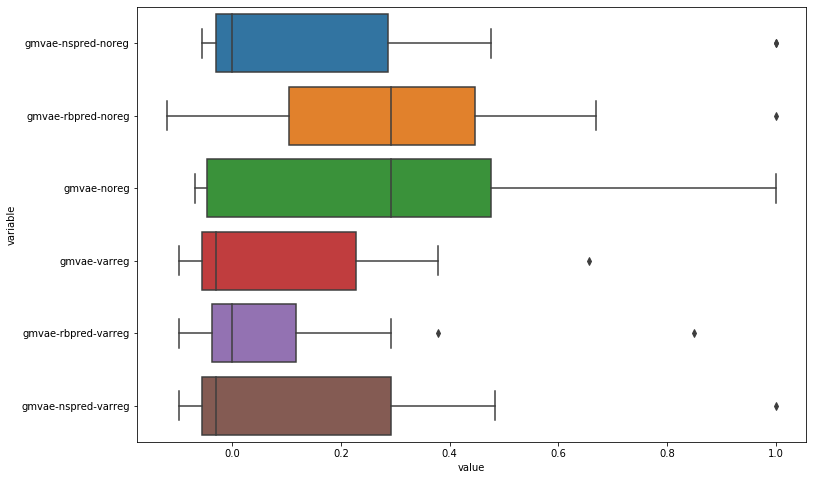

In [153]:
plt.figure(figsize=(12,8))
ari_df = pd.DataFrame(ari_dict).melt()
sns.boxplot(data=ari_df, x="value", y="variable")
plt.show()